Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [4]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install pandas==0.25 
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install matplotlib
    %matplotlib inline
# If you're working locally:
else:
    DATA_PATH = '../data/'

  Using cached https://files.pythonhosted.org/packages/1d/9a/7eb9952f4b4d73fbd75ad1d5d6112f407e695957444cb695cbb3cdab918a/pandas-0.25.0-cp36-cp36m-manylinux1_x86_64.whl
ERROR: visions 0.2.2 has requirement pandas>=0.25.3, but you'll have pandas 0.25.0 which is incompatible.
ERROR: pandas-profiling 2.5.0 has requirement pandas==0.25.3, but you'll have pandas 0.25.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.25.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
  Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


  Using cached https://files.pythonhosted.org/packages/52/3f/f6a428599e0d4497e1595030965b5ba455fd8ade6e977e3c819973c4b41d/pandas-0.25.3-cp36-cp36m-manylinux1_x86_64.whl
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 0.25.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
  Found existing installation: pandas 0.25.0
    Uninstalling pandas-0.25.0:
      Successfully uninstalled pandas-0.25.0


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [1]:
# Check Pandas Profiling version

%matplotlib inline
import pandas_profiling


pandas_profiling.__version__

'2.5.0'

In [4]:
# Old code for Pandas Profiling version 2.3
# It can be very slow with medium & large datasets.
# These parameters will make it faster.

# profile = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )
#

# New code for Pandas Profiling version 2.4
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [5]:
train_new, val = train_test_split(train)

df_train = train_new.copy()
df_val = val.copy()
df_test = test.copy()

df_train.shape, df_val.shape, df_test.shape, train.shape, test.shape

((44550, 41), (14850, 41), (14358, 40), (59400, 41), (14358, 40))

In [6]:
df_train.shape[0] + df_val.shape[0] == train.shape[0]

True

In [7]:
target = 'status_group'

df_train[target].value_counts(normalize=True)

functional                 0.544422
non functional             0.383053
functional needs repair    0.072525
Name: status_group, dtype: float64

In [8]:
target = 'status_group'

df_train[target].value_counts(normalize=True)

functional                 0.544422
non functional             0.383053
functional needs repair    0.072525
Name: status_group, dtype: float64

In [9]:
majority_class = df_train[target].mode()[0]

print(f'Majority class of {target}: {majority_class}')

Majority class of status_group: functional


In [10]:
from sklearn.metrics import accuracy_score

y_true = df_train[target]
y_pred = [majority_class] * len(y_true)
accuracy_baseline_train = accuracy_score(y_true, y_pred)

y_true = df_val[target]
y_pred = [majority_class] * len(y_true)
accuracy_baseline_val = accuracy_score(y_true, y_pred)

print(f'Baseline accuracy, train: {accuracy_baseline_train * 100:.2f}%')
print(f'Baseline accuracy, val: {accuracy_baseline_val * 100:.2f}%')

Baseline accuracy, train: 54.44%
Baseline accuracy, val: 53.91%


In [0]:
def describe_numeric_with_unique(df):
  df_described = df.describe(include='number').T
  df_described['unique'] = df.select_dtypes(include='number').nunique()
  return df_described[['count', 'unique', 'mean', 'std', 'min', 'max', '25%', '50%', '75%']]


In [12]:
describe_numeric_with_unique(df_train)

,count,unique,mean,std,min,max,25%,50%,75%
id,44550.0,44550,37134.747632,21421.490535,0.00000,7.424700e+04,18561.000000,37105.500000,55675.750000
amount_tsh,44550.0,91,306.251085,2601.835965,0.00000,2.500000e+05,0.000000,0.000000,20.000000
gps_height,44550.0,2382,669.191493,693.723087,-90.00000,2.628000e+03,0.000000,371.000000,1321.000000
longitude,44550.0,43121,34.048437,6.613080,0.00000,4.034519e+01,33.079483,34.893856,37.171627
latitude,44550.0,43122,-5.692946,2.944373,-11.64944,-2.000000e-08,-8.525775,-5.002862,-3.325229
num_private,44550.0,59,0.478316,10.623320,0.00000,1.402000e+03,0.000000,0.000000,0.000000
region_code,44550.0,27,15.254680,17.441623,1.00000,9.900000e+01,5.000000,12.000000,17.000000
district_code,44550.0,20,5.615017,9.608045,0.00000,8.000000e+01,2.000000,3.000000,5.000000
population,44550.0,961,179.093580,470.902659,0.00000,3.050000e+04,0.000000,25.000000,213.000000
construction_year,44550.0,55,1298.992615,952.158867,0.00000,2.013000e+03,0.000000,1986.000000,2004.000000


In [13]:
df_train.describe(exclude='number',).T

,count,unique,top,freq
date_recorded,44550,351,2011-03-15,436
funder,41850,1660,Government Of Tanzania,6840
installer,41837,1878,DWE,12989
wpt_name,44550,29014,none,2702
basin,44550,9,Lake Victoria,7720
subvillage,44274,16680,Madukani,396
region,44550,21,Iringa,4043
lga,44550,125,Njombe,1941
ward,44550,2076,Igosi,243
public_meeting,42027,2,True,38260


In [0]:
def my_describe(df):
  data = {
      'type' : df.dtypes,
      'unique' : df.nunique(),
      'count' : df.notnull().sum(),
      'nulls' : df.isnull().sum(),
      'mode' : [f'{df[column].mode()[0]}' for column in df.columns]
  }
  return pd.DataFrame(data)

In [15]:
desc = my_describe(df_train)
desc.sort_values(by=desc.columns.tolist())

,type,unique,count,nulls,mode
district_code,int64,20,44550,0,1
region_code,int64,27,44550,0,11
construction_year,int64,55,44550,0,0
num_private,int64,59,44550,0,0
population,int64,961,44550,0,0
gps_height,int64,2382,44550,0,0
id,int64,44550,44550,0,0
amount_tsh,float64,91,44550,0,0.0
longitude,float64,43121,44550,0,0.0
latitude,float64,43122,44550,0,-2e-08


In [0]:
features_to_drop = [target, 'id', 'recorded_by']

features = df_train.columns.drop(features_to_drop)

cardinality = df_train.select_dtypes(exclude='number').nunique()
low_cardinality_features = cardinality[cardinality <= 50].index.drop(features_to_drop, errors='ignore').tolist()

X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

y_train = df_train[target]
y_val = df_val[target]

In [17]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(cols=low_cardinality_features, use_cat_names=True),
    ce.OrdinalEncoder(),
    SimpleImputer(),
    DecisionTreeClassifier()
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity',
                                     'quantity_group', 'source', 'source_type',
                                     'source_class', '...
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_

In [18]:
accuracy_val = pipeline.score(X_val, y_val)
print(f'Decision Tree validation accuracy: {accuracy_val * 100:.2f}%')

Decision Tree validation accuracy: 71.82%


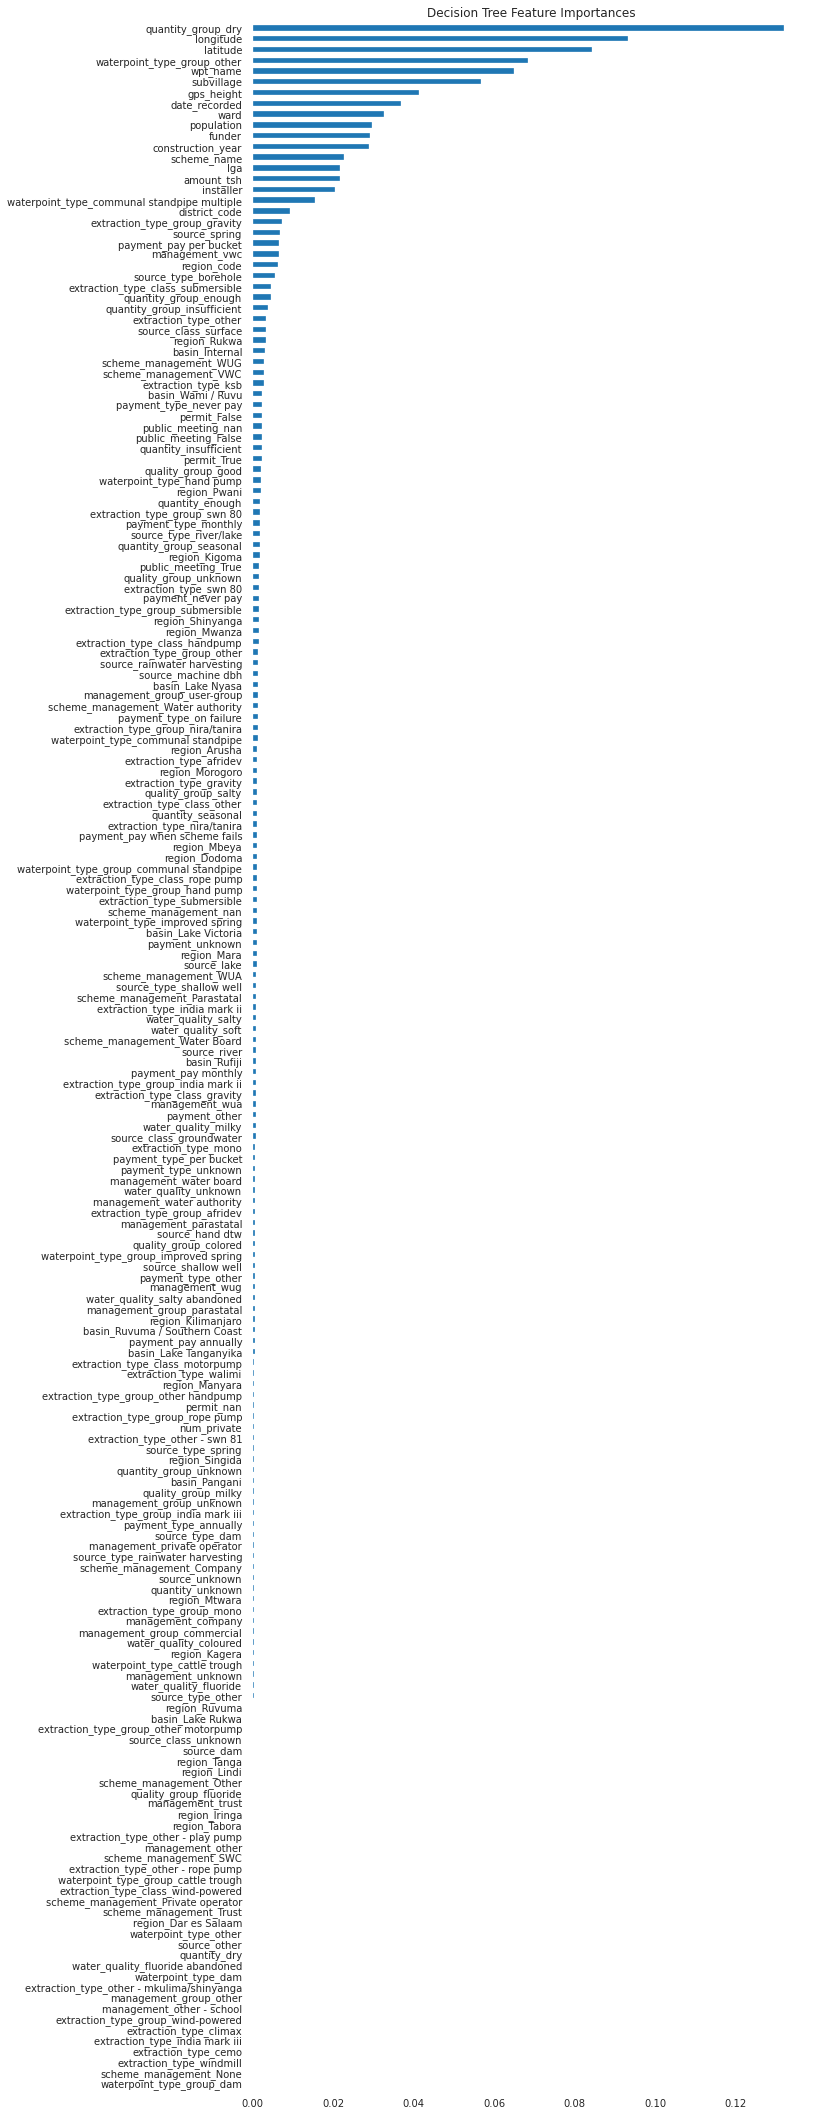

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

encoder = pipeline.named_steps['onehotencoder']
model = pipeline.named_steps['decisiontreeclassifier']

importances = pd.Series(model.feature_importances_, encoder.feature_names)

importances.sort_values().plot.barh(figsize=(10,len(importances)//5))
plt.title('Decision Tree Feature Importances')
plt.show()